In [1]:
import pandas as pd
import networkx as nx

In [2]:
df = pd.read_excel('Сетевое для питона.xlsx')
df

,Код операции,Содержание операции,Длительность операции,Предшествующая операция
0,A,Согласование плана исследования,3,-
1,B,Составление расписания фокус-групп,4,A
2,C,Составление плана полевых исследований,4,A
3,D,Отбор респондентов для фокус-групп,15,B
4,E,Организация полевого исследования 1,8,C
5,F,Организация полевого исследования 2,14,C
6,G,Проведение фокус-группы 1,3,D
7,H,Проведение фокус-группы 2,3,D
8,I,Подготовка данных полевых исследований,5,"E,F"
9,K,"Анализ данных, итоговый отчет",5,"G,H,I"


In [3]:
G = nx.DiGraph()

In [4]:
for _, row in df.iterrows():
    G.add_node(row['Код операции'], duration=row['Длительность операции'])
    if row['Предшествующая операция'] != '-':
        for pred in row['Предшествующая операция'].split(','):
            G.add_edge(pred.strip(), row['Код операции'])

In [5]:
top_order = list(nx.topological_sort(G))
df['ES'] = df['EF'] = 0
for node in top_order:
    idx = df[df['Код операции'] == node].index[0]
    df.at[idx, 'ES'] = max([df.at[df[df['Код операции'] == p].index[0], 'EF'] for p in G.predecessors(node)], default=0)
    df.at[idx, 'EF'] = df.at[idx, 'ES'] + df.at[idx, 'Длительность операции']

In [6]:
top_order

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K']

In [7]:
df['LF'] = df['LS'] = df['EF'].max()
for node in reversed(top_order):
    idx = df[df['Код операции'] == node].index[0]
    df.at[idx, 'LF'] = min([df.at[df[df['Код операции'] == s].index[0], 'LS'] for s in G.successors(node)], default=df['EF'].max())
    df.at[idx, 'LS'] = df.at[idx, 'LF'] - df.at[idx, 'Длительность операции']

In [8]:
df['Запас времени'] = df['LF'] - df['EF']
critical_path = df[df['Запас времени'] == 0]['Код операции'].tolist()
project_duration = df['EF'].max()

In [9]:
project_duration

31

In [10]:
critical_path

['A', 'C', 'F', 'I', 'K']

In [11]:
df

,Код операции,Содержание операции,Длительность операции,Предшествующая операция,ES,EF,LF,LS,Запас времени
0,A,Согласование плана исследования,3,-,0,3,3,0,0
1,B,Составление расписания фокус-групп,4,A,3,7,8,4,1
2,C,Составление плана полевых исследований,4,A,3,7,7,3,0
3,D,Отбор респондентов для фокус-групп,15,B,7,22,23,8,1
4,E,Организация полевого исследования 1,8,C,7,15,21,13,6
5,F,Организация полевого исследования 2,14,C,7,21,21,7,0
6,G,Проведение фокус-группы 1,3,D,22,25,26,23,1
7,H,Проведение фокус-группы 2,3,D,22,25,26,23,1
8,I,Подготовка данных полевых исследований,5,"E,F",21,26,26,21,0
9,K,"Анализ данных, итоговый отчет",5,"G,H,I",26,31,31,26,0


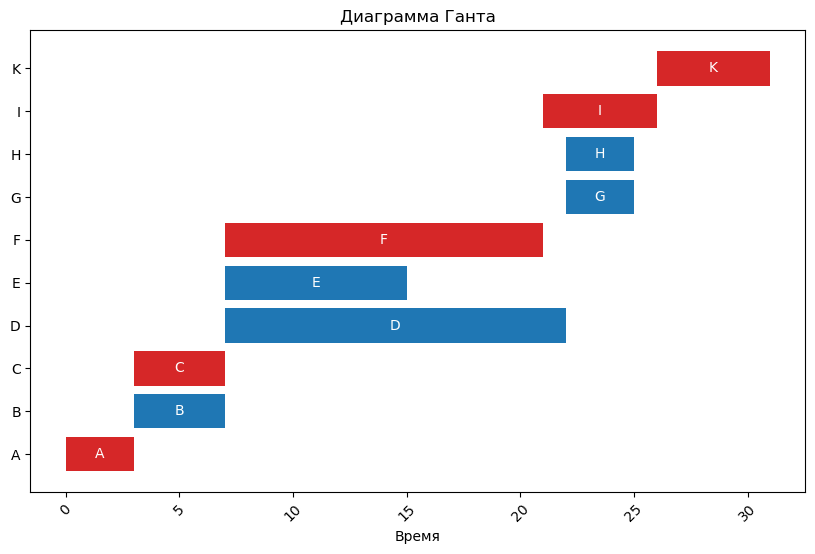

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
for i, row in df.iterrows():
    ax.broken_barh([(row['ES'], row['Длительность операции'])], (i - 0.4, 0.8), facecolors='tab:blue' if row['Запас времени'] > 0 else 'tab:red')
    ax.text(row['ES'] + row['Длительность операции'] / 2, i, row['Код операции'], ha='center', va='center', color='white')
ax.set_yticks(range(len(df)))
ax.set_yticklabels(df['Код операции'])
ax.set_xlabel("Время")
ax.set_title("Диаграмма Ганта")
plt.xticks(rotation=45)
plt.show()

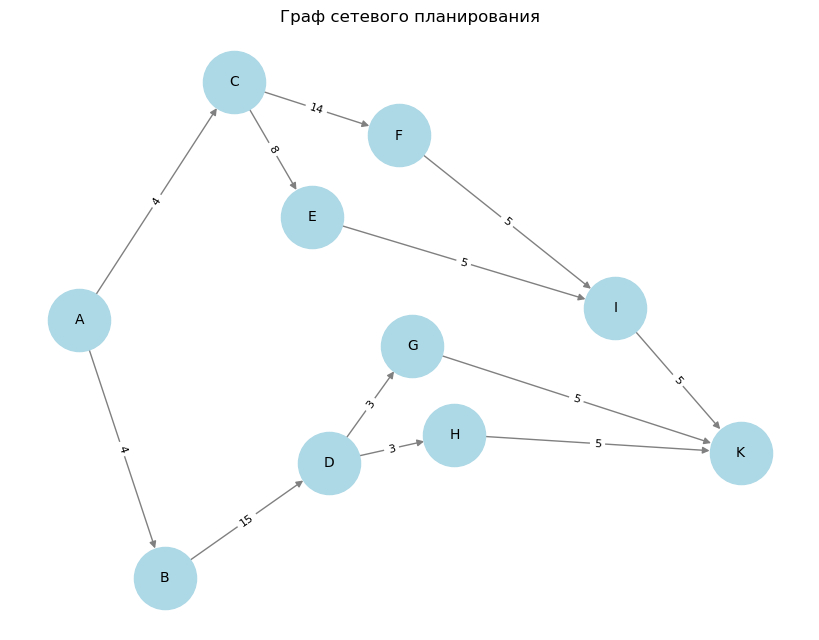

In [13]:
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=2000, font_size=10)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): G.nodes[v]['duration'] for u, v in G.edges()}, font_size=8)
plt.title("Граф сетевого планирования")
plt.show()